# Example: Multiple Asset Geometric Brownian Motion
Fill me in

## Learning objectives
Fill me in
* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`
* __Objective 1__: Compute the return covariance matrix $\Sigma$ for firms in $\mathcal{D}$
    * `Approach 1`: Use the estimated $(\hat{\mu},\hat{\sigma})$ values from `module 2` and the correlation between firms to compute $\Sigma$.
        * `Check`: Do we recover the values estimated from `module 2`?
    * `Approach 2`: An entirely data-driven approach to estimate the covariance $\Sigma$ 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [2]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [5]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [6]:
Δt = (1.0/252.0);
T = 48;
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;

## Objective 1: Compute the return covariance matrix $\Sigma$ for firms in $\mathcal{D}$
We'll use two approaches to estimate the covariance matrix $\Sigma$. We'll use the log growth (return) values in both approaches. Thus, before we begin, let's compute the log growth array for $\mathcal{L}$ firms in `dataset` $\mathcal{D}$ and store this in the `log_growth_array` variable using the `log_return_matrix(...)` function.
* The `log_growth_array` will be a `N`$\times\dim\mathcal{L}$ array, with time values on the `rows` and firms on the `columns`.

In [7]:
log_growth_array = log_return_matrix(dataset, list_of_all_firms);

### Approach 1: Use the estimated $(\hat{\mu},\hat{\sigma})$ values from `module 2` and the correlation between firms
The first approach we'll use to estimate the covariance array $\Sigma$ is to use the parameter values from the previous module and directly compute the correlation between growth (return) time series stored in the `log_growth_array` variable.

* First, let's load the `Parameters-SP500-2018-2023.csv` file we saved previously in `module 2` using the `read(...)` function exported by the [CSV.jl package](https://github.com/JuliaData/CSV.jl). We will load this data into a [DataFrame](https://dataframes.juliadata.org/stable/), storing the values in the `parameters_df` variable:

In [8]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA, "Parameters-SP500-2018-2023.csv"), DataFrame);

Next, let's compute the [correlation](https://en.wikipedia.org/wiki/Correlation) between the firms in the `dataset` $\mathcal{D}$, i.e., between the columns in the `log_growth_array`. We could do this manually; however, we'll use the [cor function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor) exported by the [Statistics module which is part of the Julia standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics). 
* The [cor function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor) takes the `log_growth_array` as an argument and produces the correlation matrix $\rho$, a symmetric $\dim\mathcal{D}\times\dim\mathcal{D}$ matrix where the elements $\rho_{ij}\in\rho$ describe the correlation between the returns of firm $i$ and $j$, and $p_{ii} = 1$. Let's store the correlation matrix in the $\rho$ variable.

In [9]:
ρ = cor(log_growth_array);

Now we can compute the covariance matrix $\Sigma$. The matrix $\Sigma$ is a $\dim\mathcal{L}\times\dim\mathcal{L}$ symmetric array, where $\sigma_{ij}\in\Sigma$ equals $\sigma_{ij} = \sigma_{i}\cdot\sigma_{j}\cdot\rho_{ij}$ and $\sigma_{i}$ denotes the volatility of the returns of firm $i$, and $\rho_{ij}$ denotes the correlation between the return of firm $i$ and $j$.
* We'll use two nested `for` loops to compute $\sigma_{ij}\in\Sigma$. First, let's initialize storage for the $\Sigma$ array in the `Σ₁` variable. In the outer loop (index `i` below), we'll select a `row_ticker` and get its volatility value $\sigma_{i}$.
* We'll then move into the inner loop (index `j` below), where we select a `column_ticker,` get $\sigma_{j}$, the volatility for firm $j$, and look up the correlation between firms $i$ and $j$. Finally, we'll compute $\sigma_{ij} = \sigma_{i}\cdot\sigma_{j}\cdot\rho_{ij}$.

In [10]:
Σ₁ = Array{Float64,2}(undef, length(list_of_all_firms), length(list_of_all_firms));
for i ∈ eachindex(list_of_all_firms)

    row_ticker = list_of_all_firms[i];
    σᵢ = parameters_df[i,:volatility];
    
    for j ∈ eachindex(list_of_all_firms)

        col_tikcer = list_of_all_firms[j];
        σⱼ = parameters_df[j,:volatility];
        Σ₁[i,j] = σᵢ*σⱼ*ρ[i,j];
    end
end

#### Check: Do we recover the values estimated from `module 2`?
The diagonal of the `Σ₁` matrix should be the variance of the return, i.e., $\sigma_{i}^{2}$ for firm $i$. Thus, we can compare the `sqrt` of the diagonal value in the `Σ₁` matrix with the volatility estimated in `module 2`. Let's do this for a random set of firms, in combination with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox).
* First, let's construct a unique set of firms and store them in the `random_test_ticker_set` variable, where we specify the number of firms in the `number_of_random_firms` variable. We'll construct the `random_test_ticker_set` using a `while` loop.

In [11]:
random_test_ticker_set = Set{String}()
number_of_random_firms = 20;
while (length(random_test_ticker_set) != number_of_random_firms)
    test_ticker = rand(list_of_all_firms)
    push!(random_test_ticker_set,test_ticker)
end

Now, let's test the previous volatility estimates for firm $i$, stored in the `σᵢ` variable, and the values computed from the diagonal values of the `Σ₁` array. We'll use a `rtol = 1e-4` threshold in the `isapprox(...)` function.

In [12]:
for ticker ∈ random_test_ticker_set
    i = findfirst(x-> x==ticker,list_of_all_firms)
    σᵢ = parameters_df[i,:volatility];
    σ̂ᵢ = sqrt(Σ₁[i,i]);
    @assert isapprox(σᵢ,σ̂ᵢ,rtol=1e-4)
end

### Approach 2: An entirely data-driven approach to estimate the covariance $\Sigma$
The second strategy we explore is an entirely data-driven approach in which we estimate the covariance matrix $\Sigma$ directly from the `log_growth_array` values. 
* This is similar to `Approach 1`, except that the volatility for firm $i$ is now estimated from the return data without the intermediate step we used in `module 2` of checking the shape of the return distribution and then estimating the volatility by fitting a model using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).
* `Approach 2` uses the [cov function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov) exported by the [Statistics module, which is part of the Julia standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics). The [cov function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov) takes the `log_growth_array` as an argument and returns the covariance matrix $\Sigma$. Let's store the annualized covariance matrix in the `Σ₂` variable.

In [13]:
Σ₂ = cov(log_growth_array) |> x-> *(x,1/252);

## Objective 2: Visualize the relationship between the returns for two firms
Covariance is often difficult to conceptualize. However, it's much easier to understand when we visualize the relationships in two dimensions. For the sake of argument, assume that returns were normally distributed (we know this is not true in most cases, but let's let that go for the time being). 
* Let's create an instance of a [multivariate Normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) where we compute the mean growth (return) values calculated from the `log_growth_array` and use `Σ₁` and `Σ₂` as the covariance. The [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl) exports the [MvNormal type](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.MvNormal) which makes this calculation convenient.

First, let;s select two `tickers` that we want to simulate and store them in the `test_ticker_array` variable:

In [14]:
test_ticker_array = ["AMD", "CLX"];

Next, let's select the appropriate values for mean and covariance. We can extract estimates for the mean by computing the mean of the `log_growth_array` for `ticker`$\in$`test_ticker_array`. Similarly, we need to extract the appropriate block from the covariance array.

In [15]:
μ_test_array = Array{Float64,1}(undef,2);
for i ∈ eachindex(test_ticker_array)
    j = findfirst(x->x == test_ticker_array[i],list_of_all_firms);
    μ_test_array[i] = mean(log_growth_array[:,j]);
end
μ_test_array;

In [16]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(test_ticker_array)
Σ₁_test_array = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
Σ₂_test_array = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(test_ticker_array)
    row_firm_index = findfirst(x->x == test_ticker_array[i],list_of_all_firms);
    for j ∈ eachindex(test_ticker_array)
        col_firm_index = findfirst(x->x == test_ticker_array[j],list_of_all_firms);
        Σ₁_test_array[i,j] = Σ₁[row_firm_index, col_firm_index]
        Σ₂_test_array[i,j] = Σ₂[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

In [17]:
Σ₁_test_array

2×2 Matrix{Float64}:
 0.114783    0.00356653
 0.00356653  0.0087963

In [18]:
Σ₂_test_array

2×2 Matrix{Float64}:
 0.211496    0.00673827
 0.00673827  0.0170404

In [19]:
m₁ = MvNormal(μ_test_array,Σ₁_test_array);
m₂ = MvNormal(μ_test_array,Σ₂_test_array);

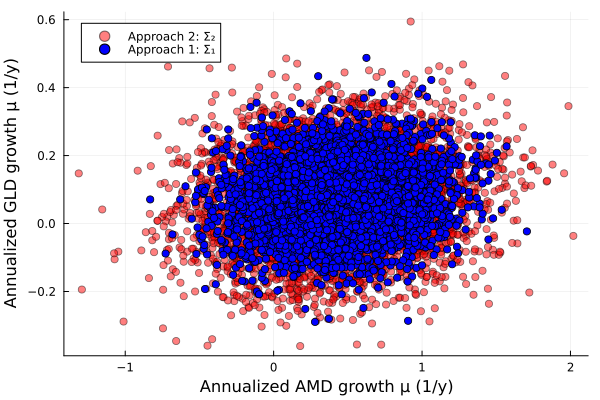

In [20]:
X₁ = rand(m₁,5000)
X₂ = rand(m₂,5000)
scatter(X₂[1,:],X₂[2,:],c=:red, alpha=0.5, label="Approach 2: Σ₂")
scatter!(X₁[1,:],X₁[2,:],c=:blue, label="Approach 1: Σ₁")
xlabel!("Annualized $(test_ticker_array[1]) growth μ (1/y)")
ylabel!("Annualized $(test_ticker_array[2]) growth μ (1/y)")

## Objective 3: Compute the performance of random portfolios for firms in $\mathcal{D}$
Fill me in

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.